# Step 1: Data Preprocessing

## Loading dataset

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'AirQualityUCI.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows to understand the data
print(df.head())

# Combine 'Date' and 'Time' into a single datetime column and set as index
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Check for missing values and handle them
df.fillna(method='ffill', inplace=True)  # Forward-fill for missing values

# Inspect the data
print(df.info())

        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000 

<ipython-input-2-17a1260436d5>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward-fill for missing values


## Feature Engineering

In [3]:
# Creating lag features for CO to capture historical dependencies
for lag in range(1, 25):  # Lag up to 24 hours
    df[f'CO_lag_{lag}'] = df['CO(GT)'].shift(lag)

# Create rolling averages (e.g., past 3-hour average)
df['CO_rolling_3'] = df['CO(GT)'].rolling(window=3).mean()
df['CO_rolling_24'] = df['CO(GT)'].rolling(window=24).mean()

# Drop initial rows with NaN values due to shifting
df.dropna(inplace=True)

# Normalize the dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns, index=df.index)

# Step 2: Splitting the Data

In [4]:
# Use the last 30 days for testing and the rest for training
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Separate features and target
X_train = train.drop(columns=['CO(GT)'])
y_train = train['CO(GT)']
X_test = test.drop(columns=['CO(GT)'])
y_test = test['CO(GT)']

In [6]:
#Check for NaNs
print(y_train.isna())  # Check for NaNs in y_train
print(X_train.isna())   # Check for NaNs in X_train

Datetime
2004-03-11 18:00:00    False
2004-03-11 19:00:00    False
2004-03-11 20:00:00    False
2004-03-11 21:00:00    False
2004-03-11 22:00:00    False
                       ...  
2005-01-16 15:00:00    False
2005-01-16 16:00:00    False
2005-01-16 17:00:00    False
2005-01-16 18:00:00    False
2005-01-16 19:00:00    False
Name: CO(GT), Length: 7466, dtype: bool
                     PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
Datetime                                                                       
2004-03-11 18:00:00        False     False     False          False    False   
2004-03-11 19:00:00        False     False     False          False    False   
2004-03-11 20:00:00        False     False     False          False    False   
2004-03-11 21:00:00        False     False     False          False    False   
2004-03-11 22:00:00        False     False     False          False    False   
...                          ...       ...       ...            ...     

# Step 3: Model Development

## Baseline Models - Moving Average

In [26]:
import pandas as pd

# Moving Average Baseline
y_pred_baseline = y_test.rolling(window=24).mean().bfill()  # Changed to bfill()

# Ensure y_train and y_test have datetime index with specified frequency
y_train.index = pd.date_range(start='10-03-2004', periods=len(y_train), freq='h')  # Adjust frequency as necessary
y_test.index = pd.date_range(start='10-03-2004', periods=len(y_test), freq='h')

In [8]:
print(y_pred_baseline)

Datetime
2005-01-16 20:00:00    0.475507
2005-01-16 21:00:00    0.475507
2005-01-16 22:00:00    0.475507
2005-01-16 23:00:00    0.475507
2005-01-17 00:00:00    0.475507
                         ...   
2005-04-04 10:00:00    0.354871
2005-04-04 11:00:00    0.355461
2005-04-04 12:00:00    0.355997
2005-04-04 13:00:00    0.356587
2005-04-04 14:00:00    0.357230
Name: CO(GT), Length: 1867, dtype: float64


## Random Forest(ML)

In [9]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [10]:
print("Random Forest Predictions:", y_pred_rf)

Random Forest Predictions: [0.46903442 0.4638873  0.45688722 ... 0.47015392 0.46537997 0.46797926]


## XGBoost(ML)

In [11]:
# XGBoost Regressor
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [12]:
print("XGBoost Predictions:", y_pred_xgb)

XGBoost Predictions: [0.47027922 0.46175605 0.45526892 ... 0.47063726 0.46658525 0.46731964]


## LSTM(DLM)

In [13]:
pip install tensorflow

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Reshape data for LSTM input (samples, timesteps, features)
#y_train = y_train.reindex(X_train.index)
#y_train = y_train.fillna(method='ffill') # Forward fill missing values if any
train_generator = TimeseriesGenerator(X_train.values, y_train.values, length=24, batch_size=32)
test_generator = TimeseriesGenerator(X_test.values, y_test.values, length=24, batch_size=32)

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(24, X_train.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Fit the LSTM model
lstm_model.fit(train_generator, epochs=20, verbose=1)
y_pred_lstm = lstm_model.predict(test_generator)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  6/233 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7342 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.1393
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3276
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2689
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2230
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2316
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1955
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1892
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1647
Epoch 9/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1848
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2043
Epoch 11/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1617
Epoch 12/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1641
Epoch 13/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1653
Epoch 14/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1637
Epoch 15/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step 

In [15]:
print("LSTM Predictions:", y_pred_lstm)

LSTM Predictions: [[0.4958497 ]
 [0.48902246]
 [0.4730008 ]
 ...
 [0.5299539 ]
 [0.4948116 ]
 [0.53197813]]


# Step 4: Model Evaluation

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

## Baseline Moving Average model

In [17]:
# Baseline
rmse_baseline, mae_baseline = evaluate(y_test, y_pred_baseline)
print(f'Moving Average - RMSE: {rmse_baseline}, MAE: {mae_baseline}')

Moving Average - RMSE: 0.4939775874035431, MAE: 0.182304593543842


## Random Forest model

In [18]:
# Random Forest
rmse_rf, mae_rf = evaluate(y_test, y_pred_rf)
print(f'Random Forest - RMSE: {rmse_rf}, MAE: {mae_rf}')

Random Forest - RMSE: 0.048246305262275004, MAE: 0.007560730376175316


## XFBoost model

In [19]:
rmse_xgb, mae_xgb = evaluate(y_test, y_pred_xgb)
print(f'XGBoost - RMSE: {rmse_xgb}, MAE: {mae_xgb}')

XGBoost - RMSE: 0.1883200836972945, MAE: 0.030733971684755702


## LSTM model

In [22]:
y_test_lstm = y_test[24:]  # Adjust y_test to match the LSTM output length
rmse_lstm, mae_lstm = evaluate(y_test_lstm, y_pred_lstm)
print(f'LSTM - RMSE: {rmse_lstm}, MAE: {mae_lstm}')

LSTM - RMSE: 0.44513273101997075, MAE: 0.15545931020243065


## Tabular representaion of all models

In [24]:
# Define the data for each model
data = {
    'Model': ['LSTM', 'XGBoost', 'Random Forest','Moving Average'],
    'RMSE': [rmse_lstm, rmse_xgb, rmse_rf, rmse_baseline],
    'MAE': [mae_lstm, mae_xgb, mae_rf, mae_baseline]
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Display the table
print(results_df)

            Model      RMSE       MAE
0            LSTM  0.445133  0.155459
1         XGBoost  0.188320  0.030734
2   Random Forest  0.048246  0.007561
3  Moving Average  0.493978  0.182305


# Step 5: Forecasting the Next 24 Hours

In [43]:
# Forecast the next 24 hours with the best-performing model
best_model = lstm_model  # Assuming LSTM performed best; replace as needed
future_steps = 24

# Use the last available data for prediction
last_24_hours = df_scaled[-24:].drop(columns=['CO(GT)']).values.reshape((1, 24, X_train.shape[1]))
forecast = best_model.predict(last_24_hours)

# Transform forecast back to original scale if necessary
forecast_original_scale = scaler.inverse_transform(
    np.concatenate(
        (forecast.reshape(-1, 1), np.zeros((forecast.shape[0], df_scaled.shape[1] - 1))),
        axis=1
    )
)[:, 0]
print("Next 24-hour CO level forecast:", forecast_original_scale)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Next 24-hour CO level forecast: [5.46298612]


In [33]:
# Forecast the next 24 hours with the best-performing model
best_model = rf_model  # Assuming LSTM performed best; replace as needed
future_steps = 24

# Use the last available data for prediction
# Reshape the input for Random Forest, which expects 2D data
last_24_hours = df_scaled[-24:].drop(columns=['CO(GT)']).values  # Remove time steps dimension

# **If your RandomForestRegressor expects a single sample, reshape to (1, n_features):**
# last_24_hours = last_24_hours.reshape(1, -1)
# **OR If you have multiple samples (e.g., the last 24 hours of each day), just use the existing 2D shape.**

forecast = best_model.predict(last_24_hours)

# Transform forecast back to original scale if necessary
forecast_original_scale = scaler.inverse_transform(
    np.concatenate(
        (forecast.reshape(-1, 1), np.zeros((forecast.shape[0], df_scaled.shape[1] - 1))),
        axis=1
    )
)[:, 0]
print("Next 24-hour CO level forecast:", forecast_original_scale)

Next 24-hour CO level forecast: [   1.179    1.322    1.437    1.435    2.369    2.281    1.694    1.66
    1.574    1.369    0.695    0.615    0.468 -193.984    0.511    0.957
    3.302    4.342    3.382    3.145    2.33     2.259    1.888    2.09 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# Step 5: Visualization

In [44]:
import matplotlib.pyplot as plt

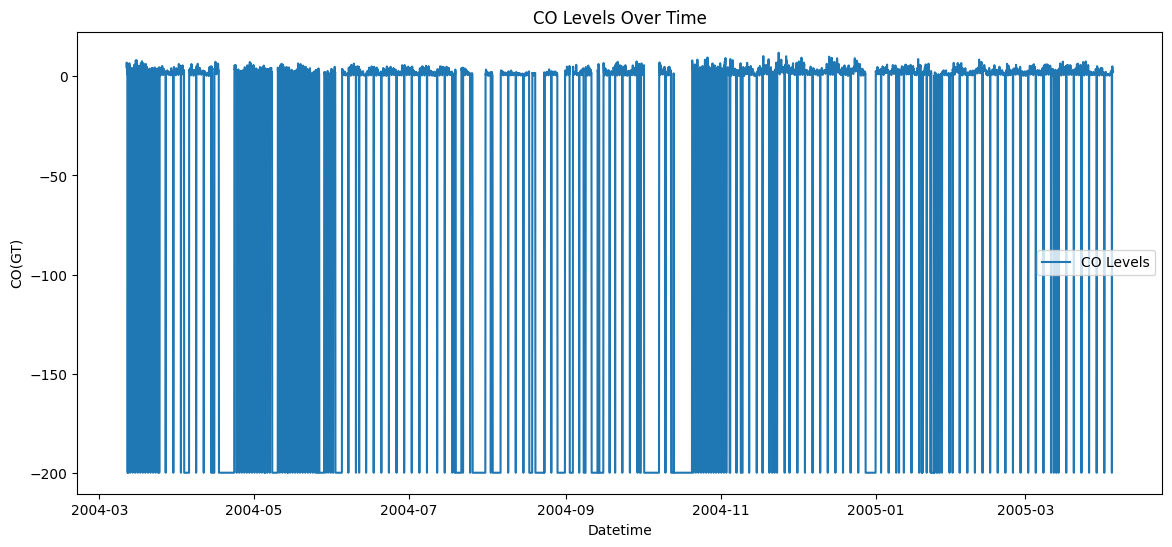

In [47]:
# Plot 1: CO Level Time-Series Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['CO(GT)'], label='CO Levels')
plt.title('CO Levels Over Time')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

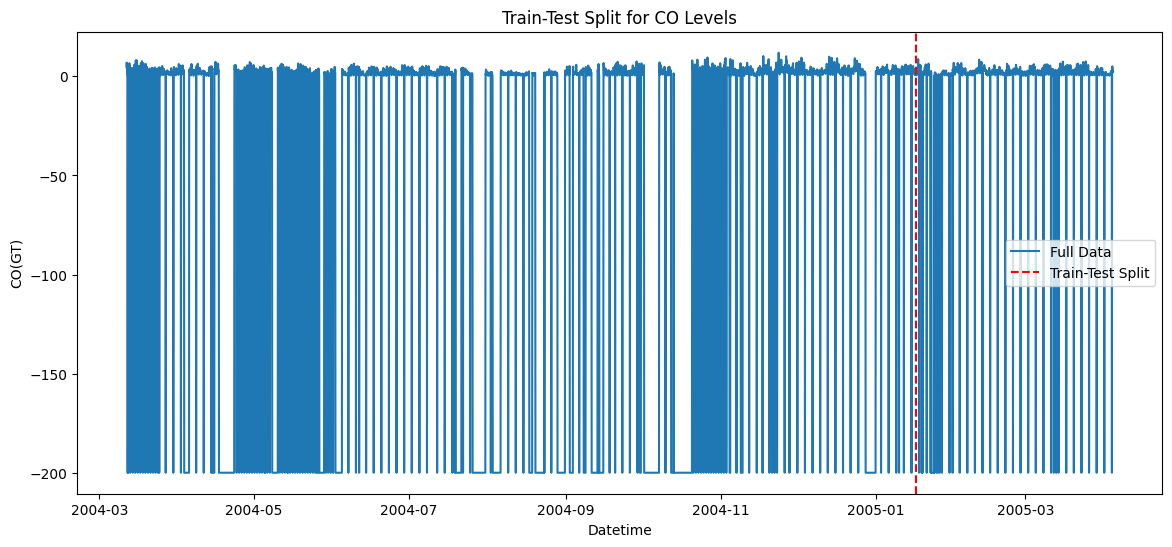

In [48]:
# Plot 2: Training and Test Data Split
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['CO(GT)'], label='Full Data')
plt.axvline(df.index[train_size], color='r', linestyle='--', label='Train-Test Split')
plt.title('Train-Test Split for CO Levels')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

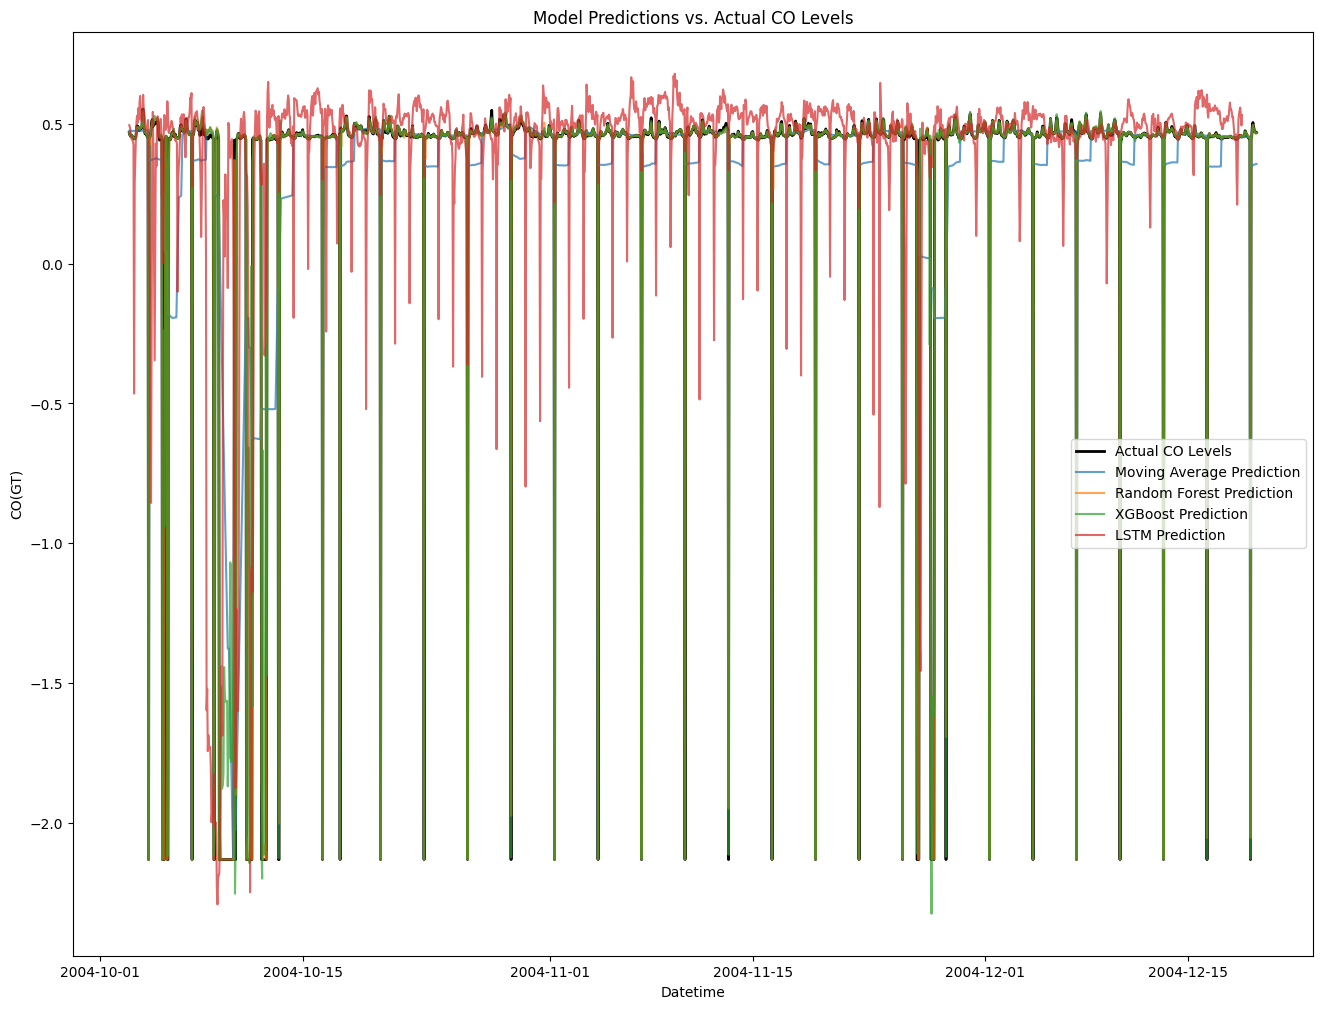

In [69]:
# Plot predictions and actuals for each model
models_predictions = {
    'Moving Average': y_pred_baseline,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LSTM': y_pred_lstm.flatten()  # Flatten the LSTM prediction array for plotting
}

plt.figure(figsize=(16, 12))
plt.plot(y_test.index, y_test, label='Actual CO Levels', color='black', linewidth=2)
for model_name, y_pred in models_predictions.items():
    y_test_aligned = y_test[:len(y_pred)]
    plt.plot(y_test_aligned.index, y_pred, label=f'{model_name} Prediction', alpha=0.7)
    plt.title('Model Predictions vs. Actual CO Levels')
    plt.xlabel('Datetime')
    plt.ylabel('CO(GT)')
plt.legend()
plt.show()

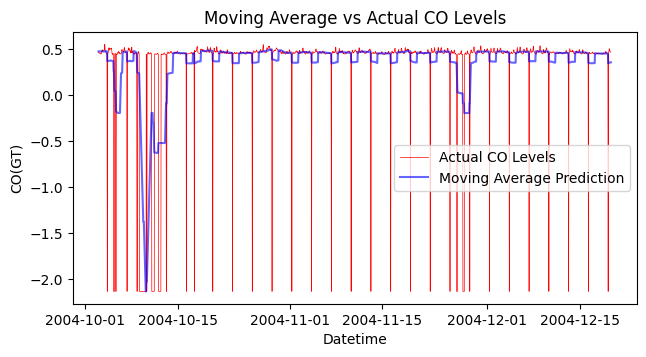

In [50]:
# Plot for Moving Average
plt.figure(figsize=(16, 12))
plt.subplot(3, 2, 1)
plt.plot(y_test.index, y_test, label='Actual CO Levels', color='red', linewidth=0.5)
plt.plot(y_test.index, y_pred_baseline, label='Moving Average Prediction', color='blue', alpha=0.6)
plt.title('Moving Average vs Actual CO Levels')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.legend()
# Adjust layout to prevent overlap

plt.show()

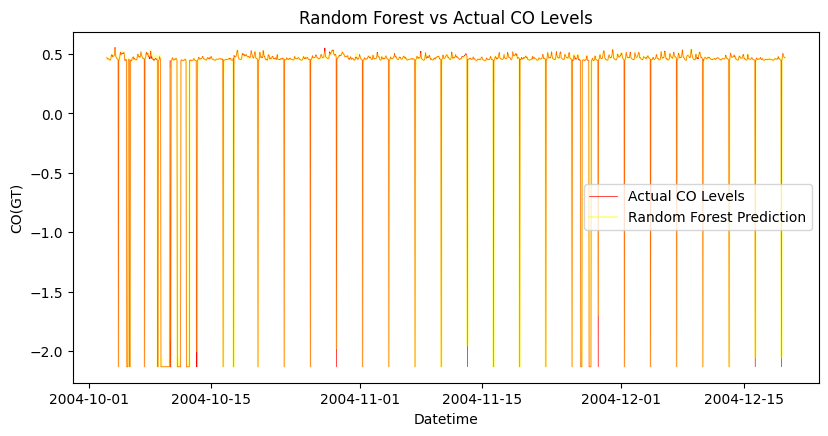

In [52]:
# Plot for Random Forest
plt.figure(figsize=(16, 12))
plt.subplot(3, 2, 3)
plt.plot(y_test.index, y_test, label='Actual CO Levels', color='red', linewidth=0.5)
plt.plot(y_test.index, y_pred_rf, label='Random Forest Prediction', color='yellow', alpha=0.4)
plt.title('Random Forest vs Actual CO Levels')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.legend()
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

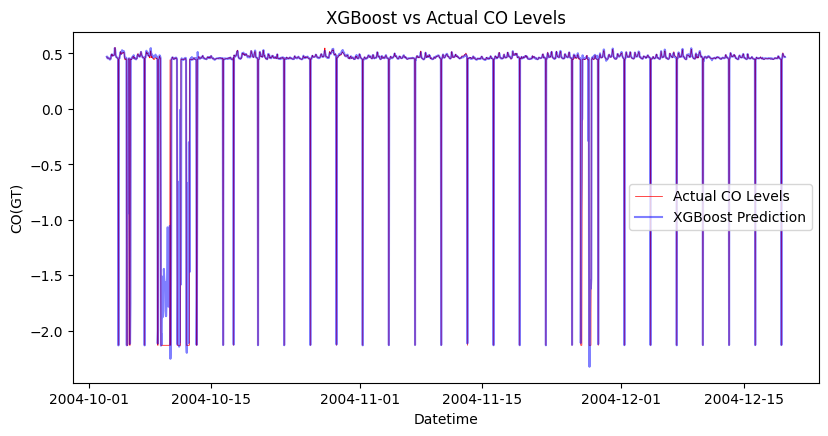

In [53]:
# Plot for XGBoost
plt.figure(figsize=(16, 12))
plt.subplot(3, 2, 4)
plt.plot(y_test.index, y_test, label='Actual CO Levels', color='red', linewidth=0.5)
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Prediction', color='blue', alpha=0.5)
plt.title('XGBoost vs Actual CO Levels')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.legend()
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

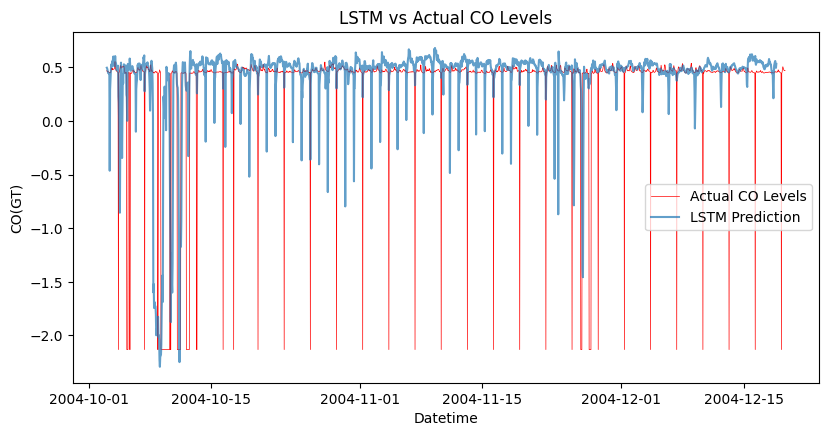

In [54]:
# Plot for LSTM
plt.figure(figsize=(16, 12))
plt.subplot(3, 2, 5)
plt.plot(y_test.index, y_test, label='Actual CO Levels', color='red', linewidth=0.5)
y_test_aligned = y_test[:len(y_pred)]
plt.plot(y_test_aligned.index, y_pred, label=f'{model_name} Prediction', alpha=0.7)
plt.title('LSTM vs Actual CO Levels')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.legend()
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

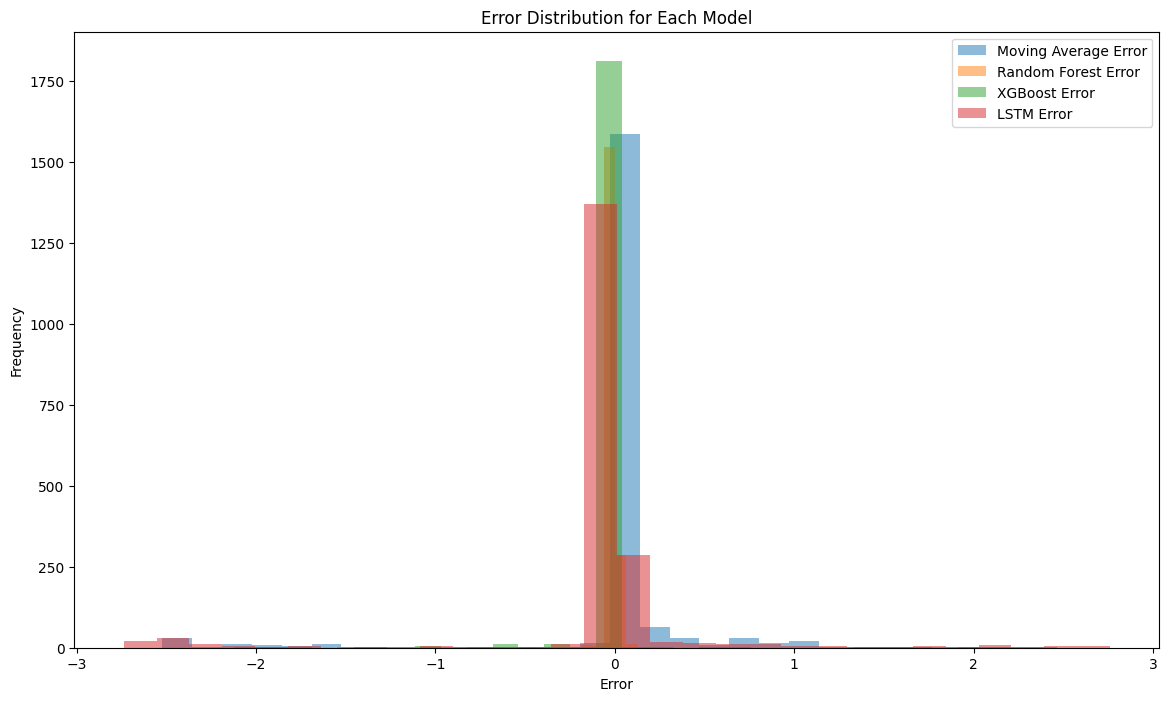

In [55]:
plt.figure(figsize=(14, 8))
for model_name, y_pred in models_predictions.items():
    # Align the lengths of y_test and y_pred
    min_len = min(len(y_test), len(y_pred))
    errors = y_test[:min_len] - y_pred[:min_len]  # Calculate errors using aligned lengths
    plt.hist(errors, bins=30, alpha=0.5, label=f'{model_name} Error')
plt.title('Error Distribution for Each Model')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()